In [1]:
import math
import random
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
%run '/Users/sabanejad/Projects/demand-response/functions.py'

In [198]:
def prepare_consumption_data(path):
    consumption_df = pd.read_parquet(path)
    consumption_df['year'] = consumption_df['date_time'].dt.year
    consumption_df['month'] = consumption_df['date_time'].dt.month
    consumption_df['day'] = consumption_df['date_time'].dt.day
    consumption_df['hour'] = consumption_df['date_time'].dt.hour

    consumption_df['DT'] = pd.to_datetime(consumption_df[['year', 'month', 'day', 'hour']])
    
    return consumption_df.loc[consumption_df['treated']]

In [184]:
total_usage_2012_control = prepare_consumption_data('data/total_usage_2012.gzip')

In [199]:
total_usage_2012_treat = prepare_consumption_data('data/total_usage_2012.gzip')

In [3]:
# import the data
total_acorn = pd.read_parquet('data/total_acorn.gzip')
# total_usage_2011 = pd.read_parquet('data/total_usage_2011.gzip')
# total_usage_2012 = pd.read_parquet('data/total_usage_2012.gzip')
total_usage_2013 = pd.read_parquet('data/total_usage_2013.gzip')
# total_usage_2014 = pd.read_parquet('data/total_usage_2014.gzip')
tariffs = pd.read_parquet('data/tariffs.gzip')

In [55]:
total_usage_2013['year'] = total_usage_2013['date_time'].dt.year
total_usage_2013['month'] = total_usage_2013['date_time'].dt.month
total_usage_2013['day'] = total_usage_2013['date_time'].dt.day
total_usage_2013['hour'] = total_usage_2013['date_time'].dt.hour

total_usage_2013['DT'] = pd.to_datetime(total_usage_2013[['year', 'month', 'day', 'hour']])

In [58]:
total_usage_2013_control = total_usage_2013.loc[~total_usage_2013['treated']]

In [7]:
temp = pd.read_csv('data/hourly.csv', usecols=['YEAR', 'MO', 'DY', 'HR', 'T2M'])
temp.columns = ['year', 'month', 'day', 'hour', 'temp']
temp['DT'] = pd.to_datetime(temp[['year', 'month', 'day', 'hour']])
temp.set_index('DT', inplace=True)

# remove feb 29, 2012
temp = temp.loc[(temp.index != '2012-02-29')]

In [44]:
temp_2013 = temp.loc[(temp['year'] == 2013)]

In [185]:
temp_2012 = temp.loc[(temp['year'] == 2012)]

In [61]:
consumption_hourly = total_usage_2013_control.groupby(
    [total_usage_2013_control['DT'], total_usage_2013_control['house_id']])['KWH/hh'].sum()
consumption_hourly.head()

DT          house_id 
2013-01-01  MAC000002    0.460
            MAC000003    3.888
            MAC000004    0.000
            MAC000006    0.000
            MAC000007    0.451
Name: KWH/hh, dtype: float64

In [63]:
consumption_hourly_mean = consumption_hourly.unstack().mean(axis=1)
consumption_hourly_mean = consumption_hourly_mean.to_frame(name='KWH/h')
joined_consumption_hourly_temp = consumption_hourly_mean.join(temp_2013, on='DT')
joined_consumption_hourly_temp.head()

,KWH/h,year,month,day,hour,temp
DT,,,,,,
2013-01-01 00:00:00,0.501423,2013,1,1,0,7.15
2013-01-01 01:00:00,0.421191,2013,1,1,1,5.79
2013-01-01 02:00:00,0.352664,2013,1,1,2,4.82
2013-01-01 03:00:00,0.299530,2013,1,1,3,4.26
2013-01-01 04:00:00,0.269880,2013,1,1,4,3.80


# same thing but for the 2012 control data to find the error?? #

In [186]:
consumption_hourly_2012 = total_usage_2012_control.groupby(
    [total_usage_2012_control['DT'], total_usage_2012_control['house_id']])['KWH/hh'].sum()
consumption_hourly_2012.head()

DT          house_id 
2012-01-01  MAC000016    0.055
            MAC000018    0.247
            MAC000019    0.214
            MAC000020    0.120
            MAC000021    0.924
Name: KWH/hh, dtype: float64

In [187]:
consumption_hourly_mean_2012 = consumption_hourly_2012.unstack().mean(axis=1)
consumption_hourly_mean_2012 = consumption_hourly_mean_2012.to_frame(name='KWH/h')
joined_consumption_hourly_temp_2012 = consumption_hourly_mean_2012.join(temp_2012, on='DT')
joined_consumption_hourly_temp_2012.head()

,KWH/h,year,month,day,hour,temp
DT,,,,,,
2012-01-01 00:00:00,0.518749,2012.0,1.0,1.0,0.0,11.12
2012-01-01 01:00:00,0.521788,2012.0,1.0,1.0,1.0,11.06
2012-01-01 02:00:00,0.430452,2012.0,1.0,1.0,2.0,11.00
2012-01-01 03:00:00,0.360427,2012.0,1.0,1.0,3.0,10.99
2012-01-01 04:00:00,0.283048,2012.0,1.0,1.0,4.0,10.96


In [201]:
consumption_hourly_t_2012 = total_usage_2012_treat.groupby(
    [total_usage_2012_treat['DT'], total_usage_2012_treat['house_id']])['KWH/hh'].sum()
consumption_hourly_mean_t_2012 = consumption_hourly_t_2012.unstack().mean(axis=1)
consumption_hourly_mean_t_2012 = consumption_hourly_mean_t_2012.to_frame(name='KWH/h')
joined_consumption_hourly_temp_t_2012 = consumption_hourly_mean_t_2012.join(temp_2012, on='DT')

In [210]:
# predict on the model constructed from 2013 control data
ydata = joined_consumption_hourly_temp_t_2012['KWH/h']
xdata = np.arange(0, len(ydata))
yguess_1 = func(xdata, -0.11670747, 2.00027143, 0.07492952, 0.42859759)
yguess_2 = f(joined_consumption_hourly_temp_2012['temp'], 27.20629354, 44.29955526, -0.51451857)
yguess = yguess_1 + yguess_2
print('RMSPE for treatment group 2012:', rmspe(ydata, yguess))
print('MSE for treatment group 2012:', mse(ydata, yguess))

RMSPE for treatment group 2012: 23.452387333785037
MSE for treatment group 2012: 0.0072376276062078105


In [209]:
# predict on the model constructed from 2013 control data
ydata = joined_consumption_hourly_temp_2012['KWH/h']
xdata = np.arange(0, len(ydata))
yguess_1 = func(xdata, -0.11670747, 2.00027143, 0.07492952, 0.42859759)
yguess_2 = f(joined_consumption_hourly_temp_2012['temp'], 27.20629354, 44.29955526, -0.51451857)
yguess = yguess_1 + yguess_2
print('RMSPE for control group 2012:', rmspe(ydata, yguess))
print('MSE for control group 2012:', mse(ydata, yguess))

RMSPE for control group 2012: 16.595946659959544
MSE for control group 2012: 0.005990838552503304


In [208]:
# predict on the model constructed from 2013 control data
ydata = joined_consumption_hourly_temp['KWH/h']
xdata = np.arange(0, len(ydata))
yguess_1 = func(xdata, -0.11670747, 2.00027143, 0.07492952, 0.42859759)
yguess_2 = f(joined_consumption_hourly_temp['temp'], 27.20629354, 44.29955526, -0.51451857)
yguess = yguess_1 + yguess_2
print('RMSPE for control group 2013:', rmspe(ydata, yguess))
print('MSE for control group 2013:', mse(ydata, yguess))

RMSPE for control group 2013: 16.91129053112695
MSE for control group 2013: 0.005027526367853909


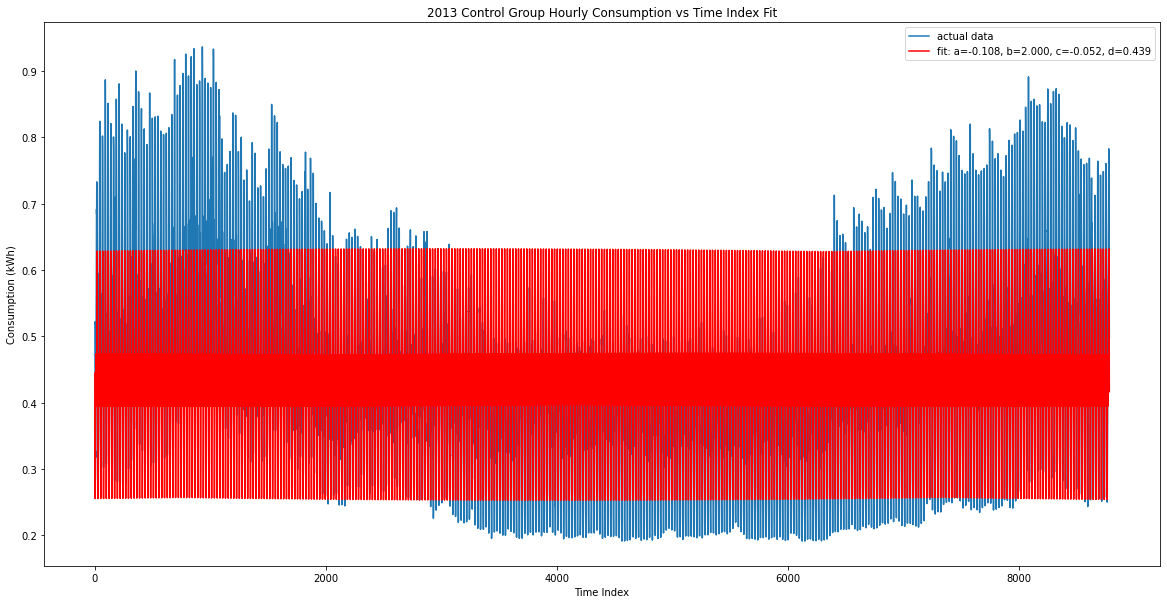

In [189]:
plt.subplots(figsize=(20, 10))
plt.plot(xdata, ydata, label='actual data')
plt.plot(xdata, yguess, 'r', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.title('2013 Control Group Hourly Consumption vs Time Index Fit')
plt.xlabel('Time Index')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

In [10]:
def func(x, a, b, c, d):
    return [a * math.sin(b*x_i*math.pi/24 + c) + a * math.sin(b*x_i*math.pi/12) + d for x_i in x]

In [88]:
ydata = joined_consumption_hourly_temp['KWH/h']
xdata = np.arange(0, len(ydata))
popt, _ = curve_fit(func, xdata, ydata, p0=(-0.16, 2, 0, 0.48))
print(popt)
yguess = func(xdata, *popt)

[-0.11670747  2.00027143  0.07492952  0.42859759]


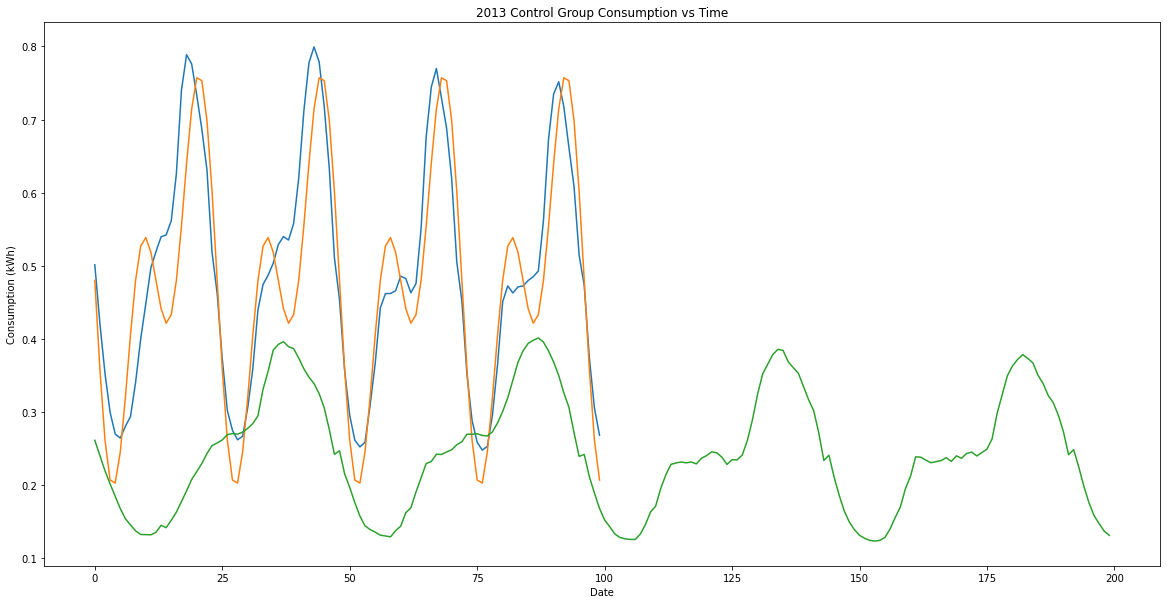

In [87]:
xdata = np.arange(0, 100)
yguess = func(xdata, 

plt.subplots(figsize=(20, 10))
plt.plot(joined_consumption_hourly_temp['KWH/h'].values[:100])
plt.plot(yguess[:100])
plt.plot(control_2013_mean_per_house_hh[:200].values)
plt.title('2013 Control Group Consumption vs Time')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.show()

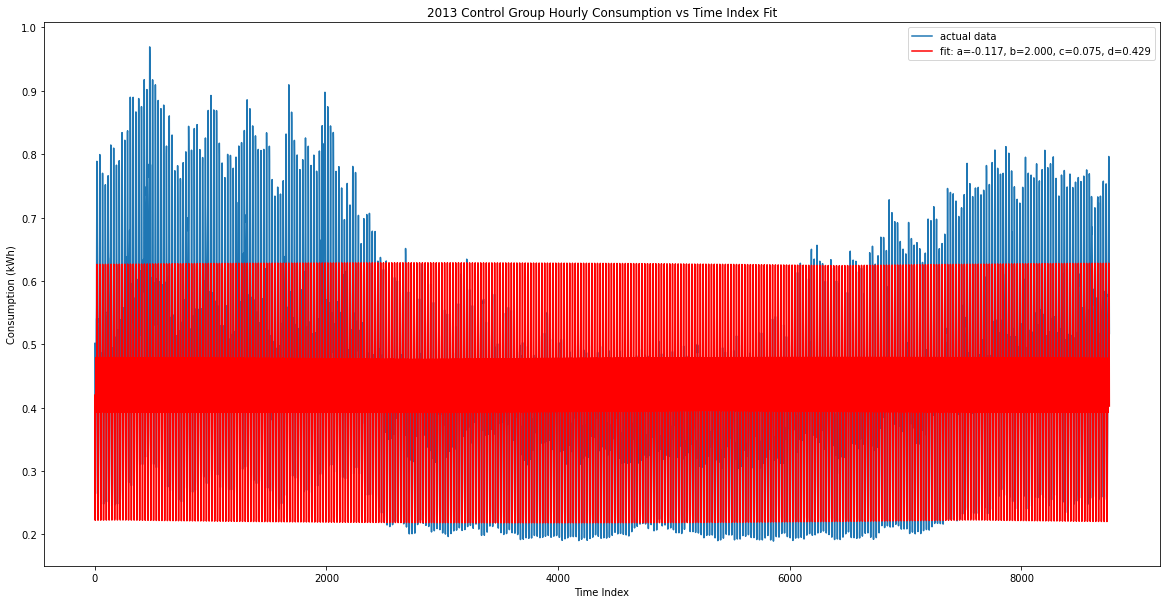

In [89]:
plt.subplots(figsize=(20, 10))
plt.plot(xdata, ydata, label='actual data')
# plt.plot(xdata, yguess, 'r', label='guess data')
plt.plot(xdata, yguess, 'r', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.title('2013 Control Group Hourly Consumption vs Time Index Fit')
plt.xlabel('Time Index')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

In [26]:
# take the mean over households per hh
control_2013_mean_per_house_hh = total_usage_2013.loc[
    ~total_usage_2013['treated']].groupby(
    total_usage_2013['DT'])['KWH/hh'].mean()

In [33]:
control_2013_mean_per_house_daily = control_2013_mean_per_house_hh.to_frame()
control_2013_mean_per_house_daily.reset_index(inplace=True)
control_2013_mean_per_house_daily = control_2013_mean_per_house_daily.groupby(
    control_2013_mean_per_house_daily['date_time'].dt.normalize()).mean()

In [11]:
ydata = control_2013_mean_per_house_hh.values
xdata = np.arange(0, len(ydata))
popt, _ = curve_fit(func, xdata, ydata, p0=(-0.08, 1, 0, 0.26))
print(popt)
yguess = func(xdata, *popt)

[-0.05909612  1.00009907  0.05407426  0.21419654]


In [207]:
def mse(y_true, y_pred):
    return np.nanmean(np.square(y_true - y_pred))

In [179]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

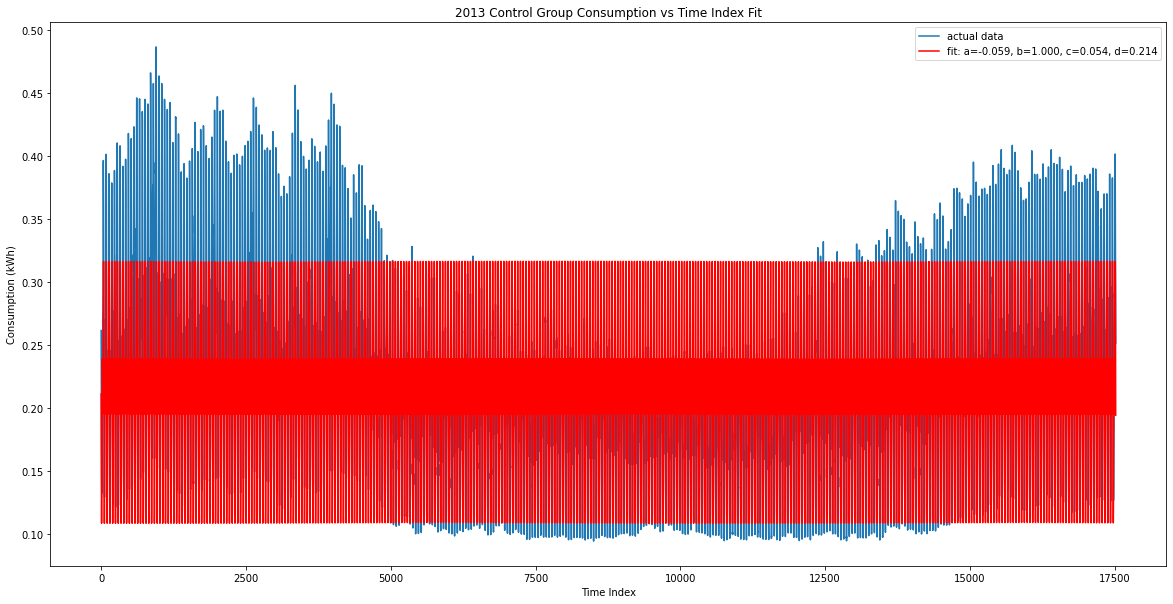

In [12]:
plt.subplots(figsize=(20, 10))
plt.plot(xdata, ydata, label='actual data')
# plt.plot(xdata, yguess, 'r', label='guess data')
plt.plot(xdata, yguess, 'r', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.title('2013 Control Group Consumption vs Time Index Fit')
plt.xlabel('Time Index')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

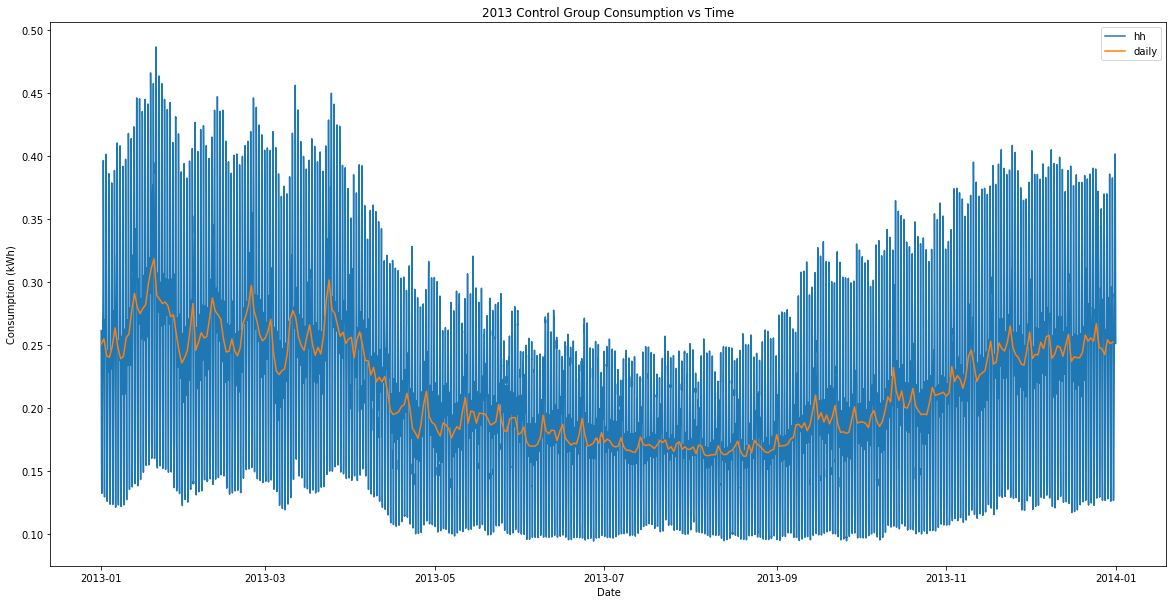

In [34]:
plt.subplots(figsize=(20, 10))
plt.plot(control_2013_mean_per_house_hh, label='hh')
plt.plot(control_2013_mean_per_house_daily, label='daily')
plt.title('2013 Control Group Consumption vs Time')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

In [104]:
residuals_daily = (ydata-yguess).to_frame().reset_index()
residuals_daily_temp = residuals_daily.join(temp_2013['temp'], on='DT')
residuals_daily_temp.head()

,DT,KWH/h,temp
0,2013-01-01 00:00:00,0.081562,7.15
1,2013-01-01 01:00:00,0.089519,5.79
2,2013-01-01 02:00:00,0.090909,4.82
3,2013-01-01 03:00:00,0.076119,4.26
4,2013-01-01 04:00:00,0.047501,3.80


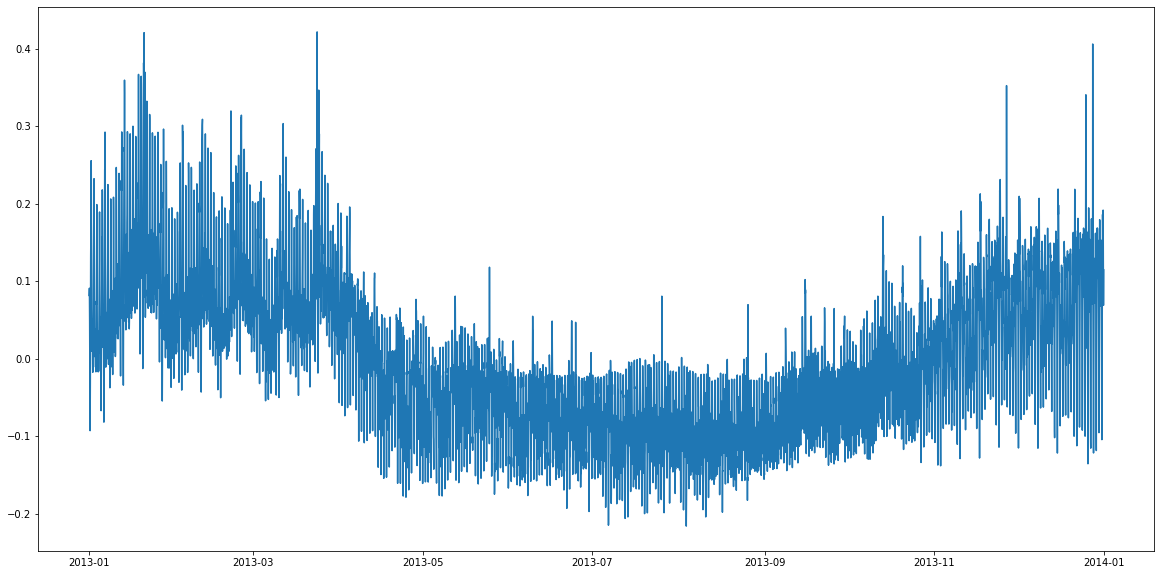

In [206]:
plt.subplots(figsize=(20, 10))
plt.plot(residuals_daily_temp['DT'], residuals_daily_temp['KWH/h'])

In [111]:
residuals_daily_temp_slice = residuals_daily_temp.loc[(residuals_daily_temp['DT'] >= '2013-01-01') & (residuals_daily_temp['DT'] < '2013-03-01')]

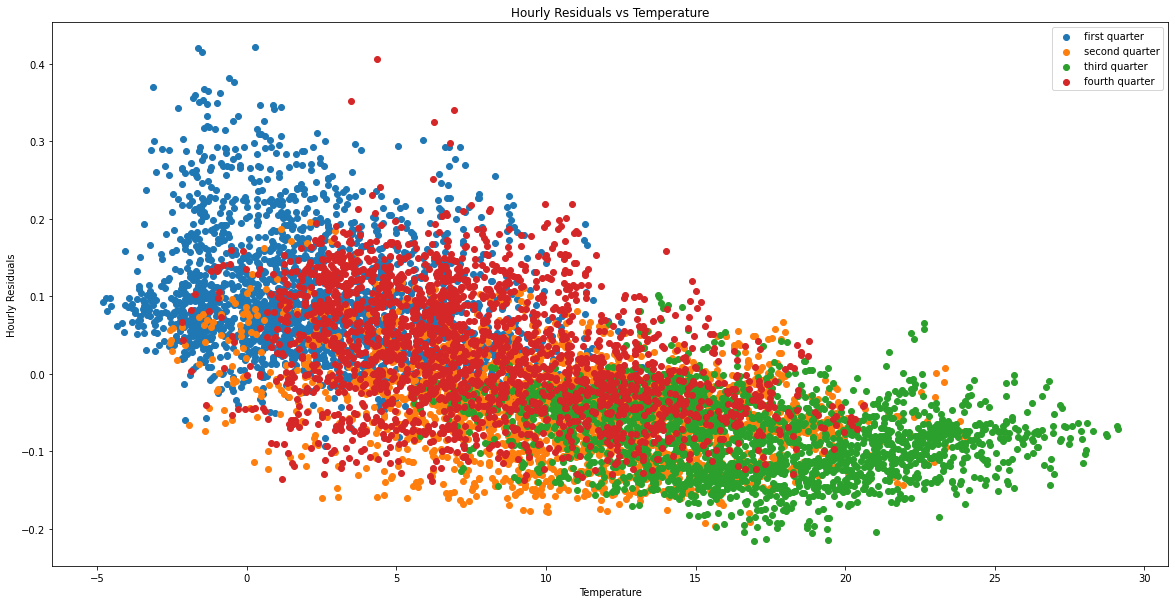

In [120]:
plt.subplots(figsize=(20, 10))
plt.scatter(residuals_daily_temp['temp'][:2190], residuals_daily_temp['KWH/h'][:2190], label='first quarter')
plt.scatter(residuals_daily_temp['temp'][2190:2*2190], residuals_daily_temp['KWH/h'][2190:2*2190], label='second quarter')
plt.scatter(residuals_daily_temp['temp'][2*2190:3*2190], residuals_daily_temp['KWH/h'][2*2190:3*2190], label='third quarter')
plt.scatter(residuals_daily_temp['temp'][3*2190:4*2190], residuals_daily_temp['KWH/h'][3*2190:4*2190], label='fourth quarter')
plt.title('Hourly Residuals vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Hourly Residuals')
plt.legend()
plt.show()

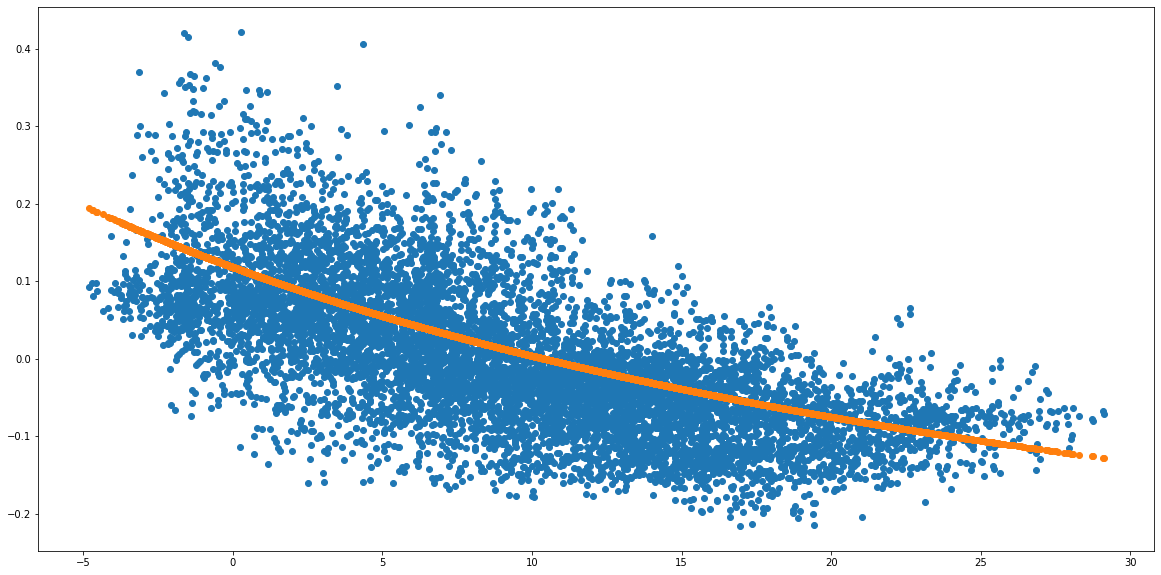

In [169]:
xdata = residuals_daily_temp['temp']
ydata = residuals_daily_temp['KWH/h']
yguess = f(xdata, 27.2, 44, -0.5)

plt.subplots(figsize=(20, 10))
plt.scatter(xdata, ydata)
plt.scatter(xdata, yguess)
plt.show()

In [121]:
def f(x, a, b, c):
    return a/(x+b) + c

[27.20629354 44.29955526 -0.51451857]


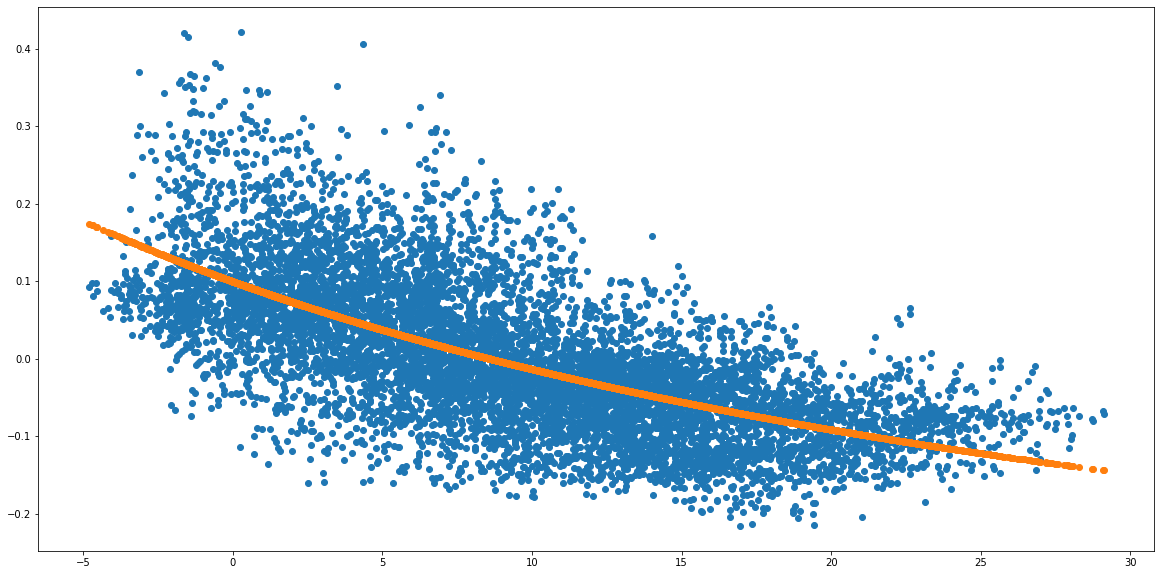

In [176]:
xdata = residuals_daily_temp['temp']
ydata = residuals_daily_temp['KWH/h']

popt, _ = curve_fit(f, xdata, ydata, p0=(100, 100, -0.1))
print(popt)
yguess = f(xdata, *popt)

plt.subplots(figsize=(20, 10))
plt.scatter(xdata, ydata)
plt.scatter(xdata, yguess)
plt.show()

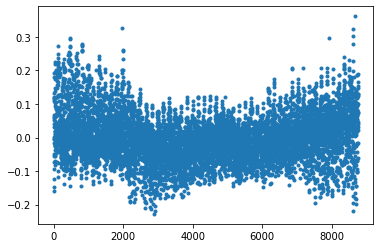

In [177]:
# plt.subplots(figsize=(20, 10))
plt.scatter(np.arange(0, len(ydata-yguess)), ydata-yguess, marker='.')
plt.show()

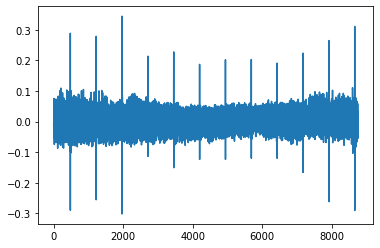

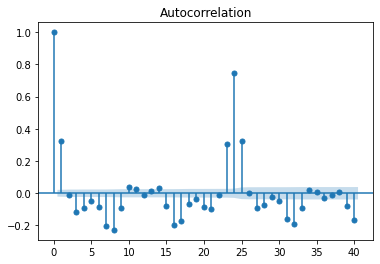

In [178]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# d = 1
plt.plot((ydata-yguess).diff())
plot_acf((ydata-yguess).diff().dropna());

In [51]:
residuals_hh = pd.DataFrame({'residuals': ydata-yguess, 'date_time': control_2013_mean_per_house_hh.index})

In [52]:
residuals_hourly = residuals_hh.groupby([residuals_hh['date_time'].dt.normalize()])['residuals'].sum()
# hourly_mean = grouped_hourly.unstack().median(axis=1)
# hourly_mean = hourly_mean.to_frame(name='KWH/h')
# joined_hourly_temp = hourly_mean.join(temp, on='DT')